In [55]:
pip install category_encoders

In [56]:
#imports
import numpy as np
import pandas as pd
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#Split
from sklearn.model_selection import train_test_split
#evaluation
from sklearn.metrics import accuracy_score

#model
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

#for sql
import sqlite3

In [57]:
#getting rid of warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [58]:
def wrangle (filepath):
  conn = sqlite3.connect(filepath)
  query = """
  select distinct(imap.building_id) as b_id,
  bs.*, dmg.damage_grade from id_map as imap
  join building_structure as bs on imap.building_id = bs.building_id
  join building_damage as dmg on imap.building_id = dmg.building_id
  where district_id = 4
  """

  #connecting and importing to df
  df = pd.read_sql(query, conn, index_col = "b_id")

  #creating a binary target
  df["severe_damage"] = df["damage_grade"].str.split(" ",expand = True)[1].astype(int) > 3
  df["severe_damage"] = df["severe_damage"]. astype(int)
  #dropping df["damage_grade"]
  df = df.drop("damage_grade", axis = 1)

  #drop all colums with post eq as they are leaky features
  leak_feat = []
  leak_feat = [leak for leak in df.columns if ("post_eq") in leak ]

  #dropping features with high cardinalitry - primary key values
  leak_feat.append("building_id")


  #dropping multi collinearity
  leak_feat.append("count_floors_pre_eq")

  #dropping the entire leak feat list of columns
  df = df.drop(columns = leak_feat)

  return df

In [59]:
df = wrangle("../content/drive/MyDrive/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


                   age_building  plinth_area_sq_ft  height_ft_pre_eq
age_building           1.000000          -0.016856          0.047652
plinth_area_sq_ft     -0.016856           1.000000          0.283496
height_ft_pre_eq       0.047652           0.283496          1.000000


<Axes: >

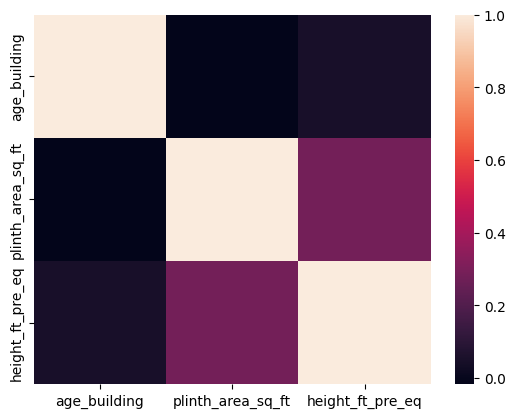

In [60]:

#checking for coll
corr = df.select_dtypes("number").drop("severe_damage", axis = 1).corr()
print(corr)
sns.heatmap(corr)

In [61]:
#Initiate splitting
target = "severe_damage"
X = df.drop(target,axis = 1)
y = df[target]
print("shape of X:  ", X.shape)
print("shape of y:  ", y.shape)

shape of X:   (70836, 11)
shape of y:   (70836,)


In [63]:
#randomized train test split
X_train, X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

In [64]:
#Train and validation split
X_train, X_val,y_train,y_val = train_test_split(X_train,
                                                y_train,
                                                test_size = 0.2,
                                                random_state = 42)

In [69]:
#baseline
acc_baseline = y_train.value_counts(normalize = True).max()
print("acc baseline: ", round(acc_baseline, 2))

acc baseline:  0.64


In [70]:
#ITERATE - Decsion tree classifier
#model building

model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
E-shape                             7
H-shape                             8
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Stone                    2
RC, engineered           3
Brick, cement mortar     4
Adobe/mud                5
Timber                   6
RC, non-engineered       7
Brick, mud mortar        8
Stone, cement mortar     9
Bamboo                  10
Other                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [74]:
#evaluate the model using the train and the validation data
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val,y_val)

print("Training accuracy", round(acc_train, 2))
print("Validation accuracy", round(acc_val, 2))

#model is not generalizing well

Training accuracy 0.98
Validation accuracy 0.65


In [76]:
#finding out the depth of the tree
depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Depth of the tree: ", depth)

Depth of the tree:  49


In [77]:
depth_hyp = range(1,50, 2)

In [80]:
#hyperparameter tuning
training_acc = []
validation_acc = []

for d in depth_hyp:
  #create the model with max_depth of d
  test_model = make_pipeline(
      OrdinalEncoder(),
      DecisionTreeClassifier(random_state = 42, max_depth = d)
  )
  #fit the model to the training data
  test_model.fit(X_train,y_train)
  #calculate the training acc and append the score to the training acc list
  training_acc.append(test_model.score(X_train,y_train))
  #calculate the validation acc and append the score to the validation acc list
  validation_acc.append(test_model.score(X_val,y_val))


print("Training accuracy: ", training_acc[:3])
print("Validation accuracy", validation_acc[:3])

Training accuracy:  [0.7071072484228174, 0.7117395332421582, 0.7162394670666608]
Validation accuracy [0.7088406564319746, 0.7132521616375508, 0.7166049055937886]


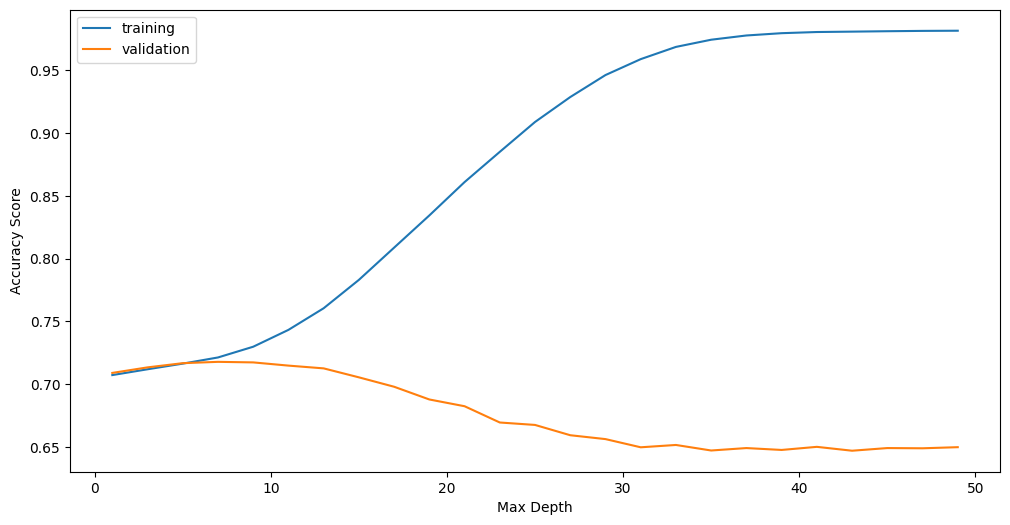

In [85]:
#Validation curve
plt.figure(figsize = (12,6))
plt.plot(
    depth_hyp,
    training_acc,
    label = "training"
)
plt.plot(
    depth_hyp,
    validation_acc,
    label = "validation"
)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [86]:
#thus the best hyperparameter value = depth : 6

In [87]:
final_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 42, max_depth = 6)
)
final_model.fit(X_train, y_train)

print("Tuned model train acc: ", final_model.score(X_train,y_train))
print("Tuned model val acc: ", final_model.score(X_val,y_val))

Tuned model train acc:  0.7187541359685887
Tuned model val acc:  0.718016587259573


In [88]:
#testing the model
test_acc = final_model.score(X_test,y_test)
print("Accuracy of tuned model", round(test_acc,3))

Accuracy of tuned model 0.723


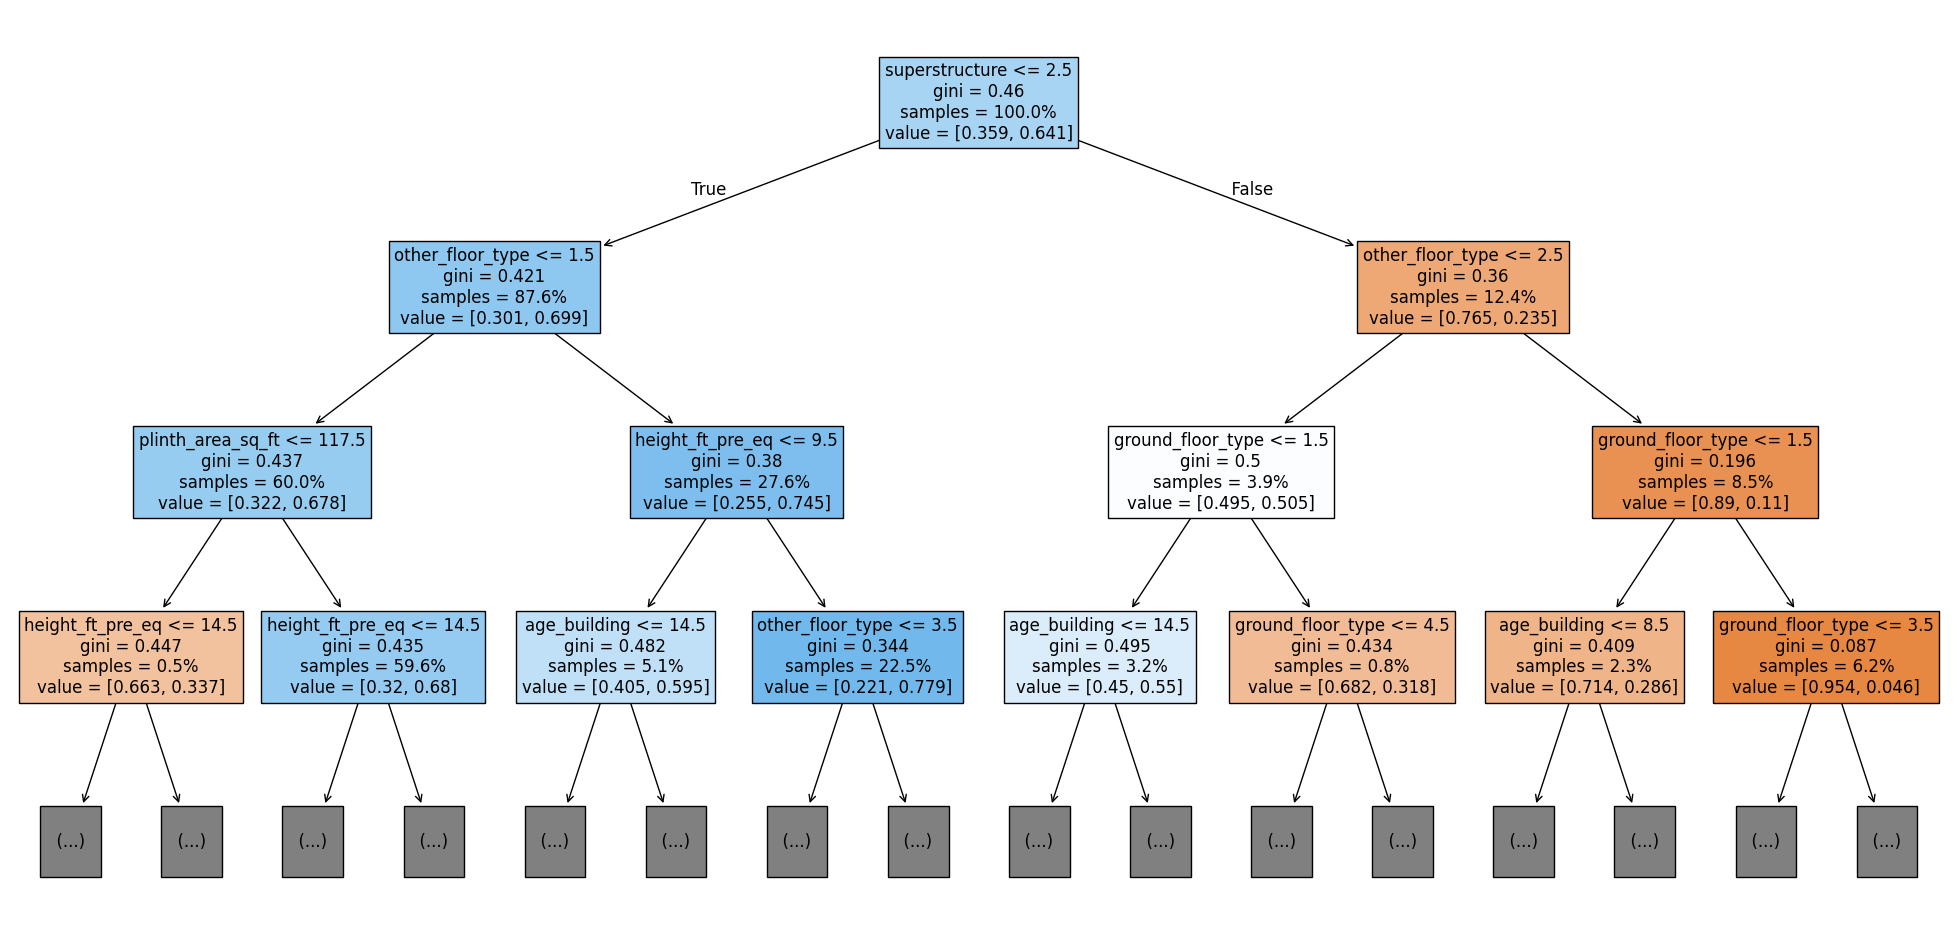

In [92]:
#communicating the results
fig, ax = plt.subplots(figsize = (25,12))
#plotting the tree
plot_tree(
    decision_tree = final_model.named_steps["decisiontreeclassifier"],
    feature_names = X_train.columns,
    filled=True,
    proportion=True,
    max_depth=3,
    ax=ax,
    fontsize = 12
);

In [109]:
#Feature Importance Matrix
features = final_model.named_steps["ordinalencoder"].get_feature_names()
importances = final_model.named_steps["decisiontreeclassifier"].feature_importances_

#creating a matrix
feat_imp = pd.DataFrame(
    {
        "importances":importances
    }
, index = features)

feat_imp = feat_imp["importances"].sort_values()

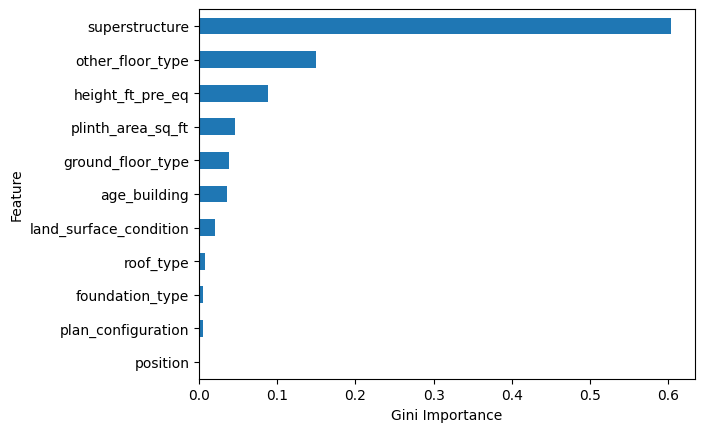

In [113]:
#gini impurity
feat_imp.plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");
#we can infer that superstructure help in 60% of the purity splits